# Despiking Data
## Import necessary modules

In [1]:
import numpy as np
import pandas as pd
#from pandas import read_csv

#from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

RE = 6378.137 # Earth radius in km

Import the data from CSV file. `pandas.read_csv` is more versatile than e.g. `numpy.genfromtxt`. The source CSV file contains the [semi-major axis](https://en.wikipedia.org/wiki/Semi-major_and_semi-minor_axes) for all objects launched with a Falcon 9 on 2020-09-03 from Launch Complex 39A (LC-39A) at Kennedy Space Center in Florida ([launch recording on Youtube](https://www.youtube.com/watch?v=_j4xR7LMCGY)). The CSV file is structured in four columns:

* `norad`: NORAD catalogue ID
* `name`: object name
* `epoch`: epoch in UTC for the semi-major axis
* `semi-major axis`: semi-major axis in [km]

The CSV file is imported to a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object with the following columns computed from the data in the CSV file:

* `norad`: NORAD catalogue ID, as above
* `name`: object name, as above
* `time`: difference between the epoch and the launch time ([pd.timedelta64](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html) object in nanoseconds)
* `alt`: mean altitutude of the orbit given as the difference between the semi-major axis and the mean Earth radius in [km]

In [2]:
datafile="data/2020-062.dat"
launch_date = "2020-09-03 12:46:14"

data_all = pd.read_csv(datafile, delimiter=',', quotechar='"', names=["norad","name","time","alt"])

data_all['time'] = pd.to_datetime(data_all['time']) - pd.to_datetime(launch_date)
data_all['alt'] = data_all['alt'] - RE

See what we got:

In [3]:
data_all

,norad,name,time,alt
0,46325,STARLINK-1734,4 days 08:21:24,224.134
1,46325,STARLINK-1734,4 days 18:43:56,225.970
2,46325,STARLINK-1734,4 days 21:42:08,228.638
3,46325,STARLINK-1734,5 days 00:40:17,228.914
4,46325,STARLINK-1734,5 days 07:13:47,228.982
...,...,...,...,...
49093,46388,FALCON 9 DEB,24 days 00:47:38,198.854
49094,46388,FALCON 9 DEB,24 days 14:02:43,191.379
49095,46388,FALCON 9 DEB,24 days 18:27:23,187.438
49096,46388,FALCON 9 DEB,24 days 22:51:49,183.387


Filter data for only one object (given by specific NORAD catalogue ID)

In [4]:
norad = 46325
#norad = 46440
#norad = 47023
obj = data_all.query('norad == @norad')
obj

,norad,name,time,alt
0,46325,STARLINK-1734,4 days 08:21:24,224.134
1,46325,STARLINK-1734,4 days 18:43:56,225.970
2,46325,STARLINK-1734,4 days 21:42:08,228.638
3,46325,STARLINK-1734,5 days 00:40:17,228.914
4,46325,STARLINK-1734,5 days 07:13:47,228.982
...,...,...,...,...
542,46325,STARLINK-1734,352 days 22:07:52,547.214
543,46325,STARLINK-1734,354 days 02:47:34,547.204
544,46325,STARLINK-1734,354 days 18:42:58,547.195
545,46325,STARLINK-1734,356 days 02:33:44,547.181


The data is not evenly sampled (the time difference between consecutive rows is not constant. To analyze the sampling period, compute the time differnce `dt` as an additional column using the [pandas dataframe diff method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html):

In [5]:
obj['dt'] = obj['time'].diff(periods=1)

/tmp/ipykernel_3057/2448056531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['dt'] = obj['time'].diff(periods=1)


Plot a histrogram for the sampling period

<IPython.core.display.Javascript object>


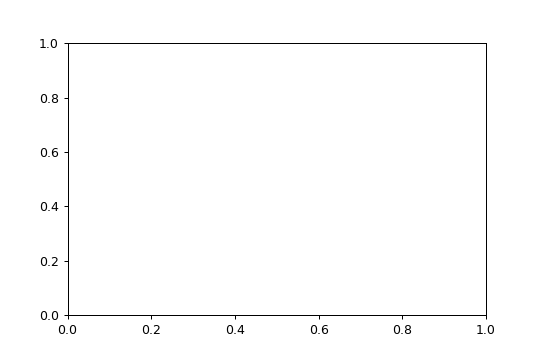

NameError: name 'timedelta' is not defined

In [6]:
dt_hist = plt.figure()
ax = dt_hist.add_subplot()

counts, bins = np.histogram(obj['dt'][1:] / timedelta(hours=1), bins=40)
percent = [i/sum(counts)*100 for i in counts]

ax.hist(bins[:-1], bins, weights=percent)
ax.set_title('Distribution of Sampling Period')
ax.set_xlabel('Sampling [h]')
ax.set_ylabel('Percentage [%]')

In the above histogram plot we see local maxima for ~ 90 minutes (the orbital period of the satellites), 9, 16 and 24 hours. The "period" of 72 hours corresponds to the time needed for the first orbital determination after launch.

Now, plot the semimajor axis over time.
`obj['time']` is of type `pd.timedelta64` and is the time difference in nanoseconds. For plotting, the value is transferred to days (after launch).

In [ ]:
alt = plt.figure()
ax = alt.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['alt'], "-")
ax.set_title("Unfiltered Object Altitude")
ax.set_xlabel("Days after launch")
ax.set_ylabel("Mean altitude [km]")

In the above plot we see spikes at around 80 days after launch. It is very unlikely that the spacecraft actually made this kind of orbit manoeuvre. The Starlink satellites have only a low thrust electric propulsion system.

Roughly, the mean altitude for the spacecraft was raised in the first ~ 56 days after launch followed by a time period with constant altitude. After ~ 125 days the altitude was again raised over the next ~ 10 days to the final operational altitude of slightly above 550 km.

## Filtering using Threshold for the 1st Derivative
Calculate the absolute value of the first derivative `abs_deriv` of alt in m/s and add this data as a new column to the dataframe `obj`. The derivative is calculated using [numpy gradient](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html).

`obj['time'] / timedelta(seconds=1)` converts from `pandas.timedelta64` to seconds.

In [ ]:
abs_deriv = abs(np.gradient(obj['alt'] * 1E3, obj['time'] / timedelta(seconds=1), edge_order = 1))
obj = obj.assign(abs_deriv = abs_deriv)

Plot the absolute value of the derivative.

In [ ]:
deriv = plt.figure()
ax = deriv.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['abs_deriv'], "-")
ax.set_yscale('log')
ax.set_title("1st Derivative of Object Altitude")
ax.set_xlabel("Days after launch")
ax.set_ylabel("Derivative [m/s]")

deriv_threshold = 1
tmin = obj['time'].min() / timedelta(days=1)
tmax = obj['time'].max() / timedelta(days=1)
ax.hlines(deriv_threshold, tmin, tmax, colors = 'r', linestyles = 'dashed')

The above plot can be interpreted as the change of the mean orbital altitude with time in units of m/s. We can rediscover the two time periods where the mean altitude was raised corresponding to relatively high values for the first derivative (~ 0.04 ... 0.09 m/s). Also the spikes can be easily identified by values for the derivative orders of magnitude higher that the hightest typical values.

Filter the altitude data using `deriv_threshold`. `obj['alt_derivfilt']` is a copy of `obj['alt_derivfilt']` with values set to nan (not a number) of `abs_deriv` exceeds `deriv_threshold`.

In [ ]:
# Create new column
obj = obj.assign(alt_derivfilt = obj['alt'])
# Set outliers to nan
obj.loc[(obj.abs_deriv > deriv_threshold), 'alt_derivfilt'] = np.nan

In [ ]:
alt_filt1 = plt.figure()
ax = alt_filt1.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['alt_derivfilt'], "-")
ax.set_title("Filtered using Threshold for 1st Derivative")
ax.set_xlabel("Days after launch")
ax.set_ylabel("Mean altitude [km]")

## Filtering using Moving Median

Define function for custom [moving median filter](https://www.mathworks.com/help/matlab/ref/movmedian.html) `movmedian`. The argument `boxhw` defines the width of the box for the filter. The width is `2 * boxhw + 1`, which ensures, that the box width is always uneven (at least while the box is not touching the boundaries).

In [ ]:
def movmedian(data, boxhw):
    data_filtered = []

    for i in range(0,len(data)):
        # Lower boundary
        lb = i - boxhw if i >= boxhw else 0
        # Upper boundary
        ub = i + boxhw if i + boxhw < len(data) else len(data)-1
        # Calculate median from array slice (sliding window)
        data_filtered.append(np.median(data[lb:ub+1]))
        #print(i, lb, ub, data[lb:ub+1], np.median(data[lb:ub+1]))

    return data_filtered

Apply filter to `obj['alt']` and create new column `obj['alt_mmfilt']` in dataframe.

In [ ]:
box_half_width = 5
obj = obj.assign(alt_mmfilt = movmedian(obj['alt'], box_half_width))

In [ ]:
alt_filt2 = plt.figure()
ax = alt_filt2.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['alt_mmfilt'], "-")
title = (
    "Filtered using Moving Median ("
    + str(box_half_width)
    + "-1-"
    + str(box_half_width)
    + ")"
)
ax.set_title(title)
ax.set_xlabel("Days after launch")
ax.set_ylabel("Mean altitude [km]")